In [1]:
from pathlib import Path
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.utils import img_to_array, array_to_img, load_img
from keras import metrics
import matplotlib.pyplot as plt

mids_dir = Path("D:\\MIDS-W207")
data = mids_dir/"datasets/soccertrack_square"
project = mids_dir/"MIDS-W207-Spring24-Soccer-Detection"
analysis = project/"analysis"

# Author: Timothy Majidzadeh
# Date Created: April 6, 2024
# Date Updated: April 6, 2024
# Description: Try logistic regression on the soccertrack_square dataset.
# Re-uses some code from T. Majidzadeh's Homework 4 and Homework 5 submissions for MIDS W207 Spring 2024.
# Notes: [v1] Created program. 
# Inputs: Frame-by-frame labels saved as separate text files.
# Outputs: Logistic regression classifiers.

In [2]:
# 1. Load the labels data and map to classes.
class_dict = {
    0: "No Objects",
    1: "Team 0 Only",
    2: "Team 1 Only",
    3: "Ball Only",
    4: "Team 0 and Team 1",
    5: "Team 0 and Ball",
    6: "Team 1 and Ball",
    7: "All Classes"
}

# Because certain class combinations are rare, it may be more effective to try each class individually.
# Remap to a value of 1 if one class is present, 0 otherwise.
ball_remap = {
    0: 0,
    1: 0,
    2: 0,
    3: 1,
    4: 0,
    5: 1,
    6: 1,
    7: 1
}

team_0_remap = {
    1: 1,
    2: 0,
    3: 0,
    4: 1,
    5: 1,
    6: 0,
    7: 1
}

team_1_remap = {
    1: 0,
    2: 1,
    3: 0,
    4: 1,
    5: 0,
    6: 1,
    7: 1
}
objects_per_image = pd.read_pickle(data/"objects_per_image_oversampled.pkl")

In [3]:
def class_mapping(ball_count, team_0_count, team_1_count):
    '''
    Assigns each row in the objects_per_image DataFrame to a class based on object counts.
    '''
    if (ball_count == 0) & (team_0_count == 0) & (team_1_count == 0):
        return 0
    elif (ball_count == 0) & (team_0_count > 0) & (team_1_count == 0):
        return 1
    elif (ball_count == 0) & (team_0_count == 0) & (team_1_count > 0):
        return 2
    elif (ball_count > 0) & (team_0_count == 0) & (team_1_count == 0):
        return 3
    elif (ball_count == 0) & (team_0_count > 0) & (team_1_count > 0):
        return 4
    elif (ball_count > 0) & (team_0_count > 0) & (team_1_count == 0):
        return 5
    elif (ball_count > 0) & (team_0_count == 0) & (team_1_count > 0):
        return 6
    else:
        return 7

In [4]:
objects_per_image.query('img_team_1_count > 0 & img_ball_count == 0')

class,image_name,img_ball_count,img_team_0_count,img_team_1_count
2632,top_view_12366.png,0,3,1
50828,top_view_7846.png,0,1,1
84552,wide_view_38197.png,0,1,3
76309,wide_view_30778.png,0,4,5
11078,top_view_19969.png,0,2,4
...,...,...,...,...
67940,wide_view_23245.png,0,4,3
28121,top_view_35306.png,0,0,4
84020,wide_view_37718.png,0,0,1
86315,wide_view_39784.png,0,4,2


In [5]:
objects_per_image['class'] = objects_per_image[
    ['img_ball_count', 'img_team_0_count', 'img_team_1_count']
].apply(lambda x: class_mapping(x.img_ball_count, x.img_team_0_count, x.img_team_1_count), axis=1)

objects_per_image['multiclass'] = objects_per_image['class']
objects_per_image['ball_binary'] = objects_per_image['class'].replace(ball_remap)
objects_per_image['team_0_binary'] = objects_per_image['class'].replace(team_0_remap)
objects_per_image['team_1_binary'] = objects_per_image['class'].replace(team_1_remap)

objects_per_image

class,image_name,img_ball_count,img_team_0_count,img_team_1_count,class,multiclass,ball_binary,team_0_binary,team_1_binary
2632,top_view_12366.png,0,3,1,4,4,0,1,1
50828,top_view_7846.png,0,1,1,4,4,0,1,1
71332,wide_view_26299.png,1,9,9,7,7,1,1,1
98211,wide_view_7900.png,0,0,0,0,0,0,0,0
84552,wide_view_38197.png,0,1,3,4,4,0,1,1
...,...,...,...,...,...,...,...,...,...
44026,top_view_49621.png,0,0,0,0,0,0,0,0
44455,top_view_50006.png,1,9,5,7,7,1,1,1
86315,wide_view_39784.png,0,4,2,4,4,0,1,1
41307,top_view_47174.png,0,0,1,2,2,0,0,1


C:\Users\timot\anaconda3\envs\tf_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='class', ylabel='Count'>

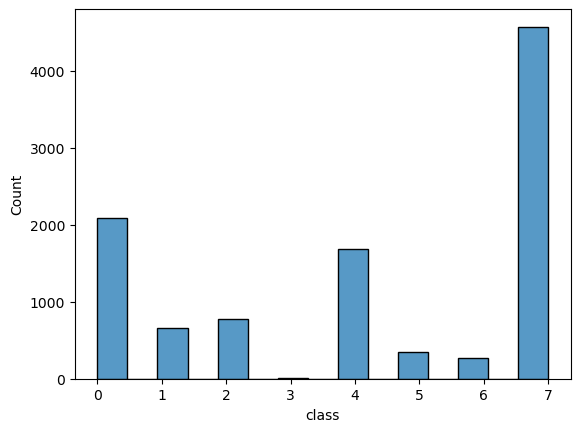

In [6]:
sns.histplot(objects_per_image['class'])

In [7]:
# 2. Load the images and match to labels. Format as NumPy arrays.
train_size, test_size = 80, 20
paths_train = [data/"images"/name for name in objects_per_image['image_name'][0:train_size]] # Data is already shuffled.
paths_test = [data/"images"/name for name in objects_per_image['image_name'][train_size:(train_size+test_size)]]

In [8]:
X_train = np.array([img_to_array(load_img(path, color_mode='grayscale', target_size=(400, 400))) for path in paths_train])
X_test = np.array([img_to_array(load_img(path, color_mode='grayscale', target_size=(400, 400))) for path in paths_test])


In [9]:
X_train, X_test = np.squeeze(X_train), np.squeeze(X_test)
X_train.shape

(80, 400, 400)

In [10]:
multiclass_train, multiclass_test = np.array(objects_per_image['multiclass'][0:train_size]), np.array(objects_per_image['multiclass'][train_size:(train_size+test_size)])
multiclass_train.shape

(80,)

In [11]:
ball_binary_train, ball_binary_test = np.array(objects_per_image['ball_binary'][0:train_size]), np.array(objects_per_image['ball_binary'][train_size:(train_size+test_size)])
ball_binary_train.shape

(80,)

In [12]:
team_0_binary_train, team_0_binary_test = np.array(objects_per_image['team_0_binary'][0:train_size]), np.array(objects_per_image['team_0_binary'][train_size:(train_size+test_size)])
team_0_binary_train.shape

(80,)

In [13]:
team_1_binary_train, team_1_binary_test = np.array(objects_per_image['team_1_binary'][0:train_size]), np.array(objects_per_image['team_1_binary'][train_size:(train_size+test_size)])
team_1_binary_train.shape

(80,)

In [14]:
# Define loss & model functions.
# Re-used from T. Majidzadeh's HW 5 submission.
# We re-formatted the data above so that it can work with this model.
def build_model(n_classes, learning_rate=0.01):
  """Build a multi-class logistic regression model using Keras.

  Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  tf.keras.backend.clear_session()
  np.random.seed(0)
  tf.random.set_seed(0)

  model = keras.Sequential()
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(
      # YOUR CODE HERE
      units=n_classes,
      activation="softmax"
  ))

  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
  # YOUR CODE HERE
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optimizer, 
                metrics=['accuracy'])
  return model

In [15]:
objects_per_image['class'].unique()

array([4, 7, 0, 1, 2, 6, 5, 3], dtype=int64)

In [16]:
# Multiclass predictor
multiclass_model = build_model(len(objects_per_image['class'].unique()))
multiclass_model.fit(
    x = X_train,
    y = multiclass_train,
    epochs = 5,
    batch_size = 64,
    validation_split = 0.1,
    verbose=1
)


Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - accuracy: 0.0856 - loss: 2550823.7500 - val_accuracy: 0.1250 - val_loss: 5404801.0000
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0712 - loss: 7137271.0000 - val_accuracy: 0.2500 - val_loss: 9732366.0000
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2159 - loss: 8796519.0000 - val_accuracy: 0.0000e+00 - val_loss: 9385886.0000
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0434 - loss: 9093494.0000 - val_accuracy: 0.3750 - val_loss: 11603648.0000
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.5093 - loss: 7119684.5000 - val_accuracy: 0.2500 - val_loss: 4337132.0000


In [17]:
def plot_confusion_matrix(labels, predictions, names):
    '''
    Plot a confusion matrix given a set of labels, names, and predictions.
    '''
    # Create a confusion matrix as a 2D array.
    confusion_matrix = tf.math.confusion_matrix(labels, predictions)
    
    # Use a heatmap plot to display it.
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     xticklabels=names, yticklabels=names, cbar=False)
    
    # Add axis labels.
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


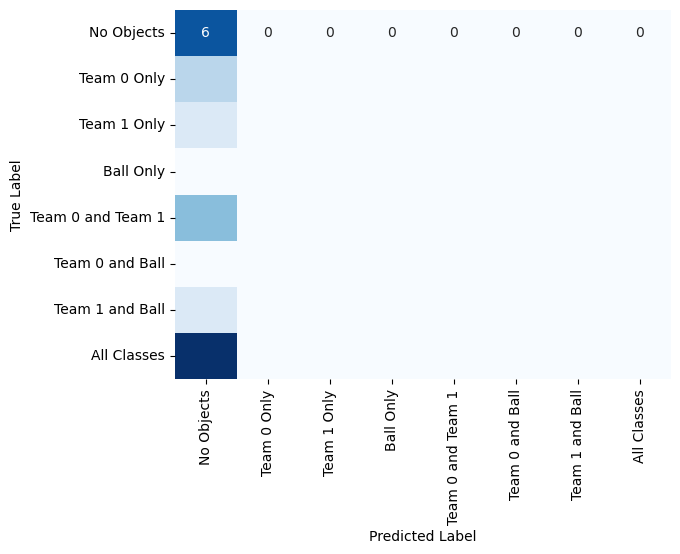

In [18]:
multiclass_predictions = np.argmax(multiclass_model.predict(X_test), axis=-1)
print(multiclass_predictions)
plot_confusion_matrix(multiclass_test, multiclass_predictions, class_dict.values())

In [19]:
# Ball presence predictor
ball_binary_model = build_model(2)
ball_binary_model.fit(
    x = X_train,
    y = ball_binary_train,
    epochs = 5,
    batch_size = 64,
    validation_split = 0.1,
    verbose=1
)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.5145 - loss: 2626841.0000 - val_accuracy: 0.3750 - val_loss: 815561.5000
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5289 - loss: 3395460.0000 - val_accuracy: 0.3750 - val_loss: 2852045.0000
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5289 - loss: 3754575.2500 - val_accuracy: 0.3750 - val_loss: 4888529.5000
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5289 - loss: 4113690.5000 - val_accuracy: 0.3750 - val_loss: 6925015.0000
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5289 - loss: 4472806.0000 - val_accuracy: 0.3750 - val_loss: 8961497.0000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


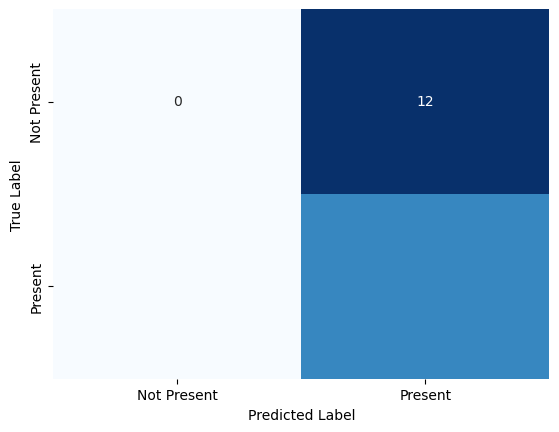

In [20]:
ball_binary_predictions = np.argmax(ball_binary_model.predict(X_test), axis=-1)
print(ball_binary_predictions)
plot_confusion_matrix(ball_binary_test, ball_binary_predictions, ["Not Present", "Present"])

In [21]:
# Ball presence predictor
team_0_binary_model = build_model(2)
team_0_binary_model.fit(
    x = X_train,
    y = team_0_binary_train,
    epochs = 5,
    batch_size = 64,
    validation_split = 0.1,
    verbose=1
)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7222 - loss: 1758983.8750 - val_accuracy: 0.7500 - val_loss: 3330137.2500
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7263 - loss: 3715995.0000 - val_accuracy: 0.2500 - val_loss: 3802551.0000
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2922 - loss: 5018434.5000 - val_accuracy: 0.7500 - val_loss: 2583643.0000
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7263 - loss: 2456584.7500 - val_accuracy: 0.2500 - val_loss: 7060700.5000
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2922 - loss: 6526796.0000 - val_accuracy: 0.7500 - val_loss: 1837150.5000


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


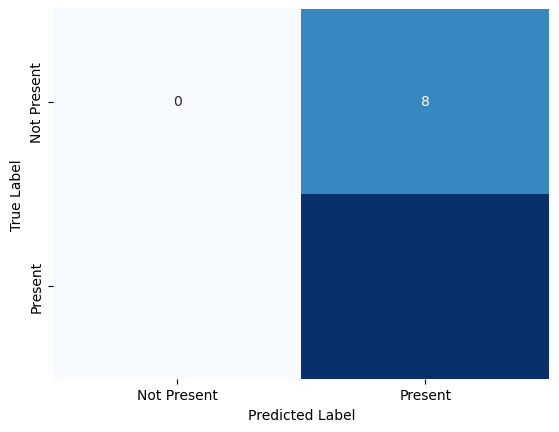

In [22]:
team_0_binary_predictions = np.argmax(team_0_binary_model.predict(X_test), axis=-1)
print(team_0_binary_predictions)
plot_confusion_matrix(team_0_binary_test, team_0_binary_predictions, ["Not Present", "Present"])

In [23]:
# Ball presence predictor
team_1_binary_model = build_model(2)
team_1_binary_model.fit(
    x = X_train,
    y = team_1_binary_train,
    epochs = 5,
    batch_size = 64,
    validation_split = 0.1,
    verbose=1
)

Epoch 1/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.7078 - loss: 2149931.5000 - val_accuracy: 0.6250 - val_loss: 4932944.0000
Epoch 2/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7263 - loss: 3188885.0000 - val_accuracy: 0.3750 - val_loss: 5521619.0000
Epoch 3/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2922 - loss: 6527764.0000 - val_accuracy: 0.6250 - val_loss: 3042021.5000
Epoch 4/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7170 - loss: 1663595.2500 - val_accuracy: 0.6250 - val_loss: 6341554.0000
Epoch 5/5
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7263 - loss: 4386844.0000 - val_accuracy: 0.3750 - val_loss: 2266027.2500


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


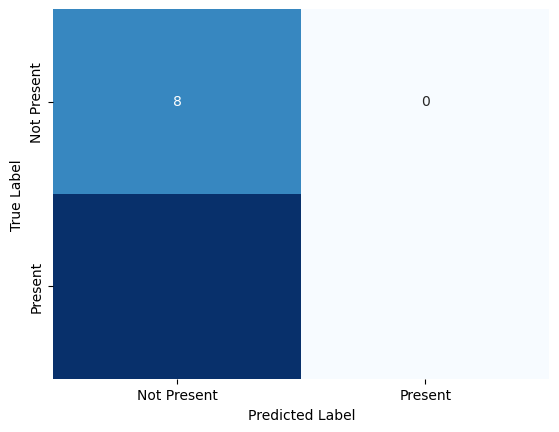

In [24]:
team_1_binary_predictions = np.argmax(team_1_binary_model.predict(X_test), axis=-1)
print(team_1_binary_predictions)
plot_confusion_matrix(team_1_binary_test, team_1_binary_predictions, ["Not Present", "Present"])